# Imports

In [1]:
import os
import pickle
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from pfc_packages.pointNet import *
from pfc_packages.utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Hyperparameters

In [11]:
NUM_CLASSES = 20
INPUT_CHANNELS = 29
EPOCHS = 41
LR = 0.001
DECAY_RATE = 0.0001
MOMENTUM_DECAY_STEP = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "checkpoints_to_ignore/models/modelV2"
SEQ_LIST = [1]
SEQ_LIST_NAME = "".join(str(s) for s in SEQ_LIST)

# Model configs

In [12]:
# ==== MODEL ====
model = PointNetSeg(num_classes=NUM_CLASSES, input_channels=INPUT_CHANNELS).to(DEVICE)
model.load_state_dict(
    torch.load("checkpoints_to_ignore/models/modelV2_e039_s023458910_ic29.pth")
)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    eps=1e-08, weight_decay=DECAY_RATE
)

In [4]:
"""
desativar todas as regularizações
tentar aumentar o máximo possível o tamanho do dataset
aumentar o modelo se necessário
ideia do padding se necessária la pra frente
aumentar os features, desvio padrado de cada coordenada, bean numpy histograma
tentar manter o valor da acurácia em 90%
"""

'\ndesativar todas as regularizações\ntentar aumentar o máximo possível o tamanho do dataset\naumentar o modelo se necessário\nideia do padding se necessária la pra frente\naumentar os features, desvio padrado de cada coordenada, bean numpy histograma\ntentar manter o valor da acurácia em 90%\n'

# Pre-process clusters

In [5]:
## ==== LOAD DATA ====
lista_train = [4]
processed_train_dataset = []

for i in lista_train:
    SEQ_LIST = [i]
    SEQ_LIST_NAME = "".join(str(s) for s in SEQ_LIST)
    print(SEQ_LIST_NAME)

#     unprocessed_train_dataset = SemanticKittiDataset(
#         "../../datasets/semantic-kitti", load_cluster=True, sequence_list=SEQ_LIST
#     )

#     processed_train_dataset = []

#     for frame in tqdm(unprocessed_train_dataset, desc="Processando frames"):
#         processed_train_dataset.append(
#             extract_features_from_clusters(frame, min_cluster_size=3, num_bins=2)
#         )


# ####################################################################################################
# ####################################################################################################
#     with open(f"./checkpoints_to_ignore/processed_train_dataset/seq{SEQ_LIST_NAME}_bin2.pkl", "wb") as f:
#         pickle.dump(processed_train_dataset, f)

####################################################################################################
####################################################################################################
    with open(
        f"./checkpoints_to_ignore/processed_train_dataset/seq{SEQ_LIST_NAME}.pkl", "rb"
    ) as f:
        p = pickle.load(f)
    processed_train_dataset.extend(p)

    print(len(processed_train_dataset))
    print(processed_train_dataset[0].shape)

4
271
(525, 29)


In [ ]:
lista_validation = [101]
processed_validation_dataset = []

for i in lista_validation:
    SEQ_LIST = [i]
    SEQ_LIST_NAME = "".join(str(s) for s in SEQ_LIST)
    print(SEQ_LIST_NAME)

    unprocessed_validation_dataset = SemanticKittiDataset(
        "../../datasets/semantic-kitti", load_cluster=True, sequence_list=SEQ_LIST
    )

    processed_validation_dataset = []

    for frame in tqdm(unprocessed_validation_dataset, desc="Processando frames"):
        processed_validation_dataset.append(
            extract_features_from_clusters(frame, min_cluster_size=3)
        )

    # ####################################################################################################
    # ####################################################################################################
    #     # with open(f"./checkpoints_to_ignore/processed_train_dataset/seq{SEQ_LIST_NAME}.pkl", "wb") as f:
    #     #     pickle.dump(processed_train_dataset, f)

    # ####################################################################################################
    # ####################################################################################################
    # with open(
    #     f"./checkpoints_to_ignore/processed_train_dataset/seq{SEQ_LIST_NAME}.pkl", "rb"
    # ) as f:
    #     p = pickle.load(f)
    # processed_validation_dataset.extend(p)

    print(len(processed_validation_dataset))

1
1101
6
2202
7
3303


In [ ]:
print("Train dataset size: ")
max_clusters = max(f.shape[0] for f in processed_train_dataset)
print(max_clusters, len(processed_train_dataset))
print(processed_train_dataset[0].shape, processed_train_dataset[0][0])
print("\n\nValidation dataset size: ")
max_clusters = max(f.shape[0] for f in processed_validation_dataset)
print(max_clusters, len(processed_validation_dataset))
print(processed_validation_dataset[0].shape, processed_validation_dataset[0][0])


lista_train = [0, 2, 3, 4, 5, 8, 9, 10]
SEQ_LIST_NAME = "".join(str(s) for s in lista_train)
SEQ_LIST_NAME

Train dataset size: 
561 5
(525, 26) [ 2.79801526e-01  3.48418242e-01 -1.78531399e+00  4.95725021e+01
  4.80397911e+01 -4.18564945e-01 -4.85655937e+01 -3.51228294e+01
 -3.22015285e+00  7.06828191e-04  6.35433065e-03  3.73243640e-02
  6.04201121e-03  5.21080318e-04  1.69343726e-03  2.49573469e-02
  2.95675827e-02  3.55951590e-03  3.45282741e-04  2.27636665e-02
  1.59940668e-01  1.35597365e+00  2.33337178e-01  1.26870013e-02
  9.00000000e+00  0.00000000e+00]


Validation dataset size: 
525 1
(525, 26) [ 2.79801526e-01  3.48418242e-01 -1.78531399e+00  4.95725021e+01
  4.80397911e+01 -4.18564945e-01 -4.85655937e+01 -3.51228294e+01
 -3.22015285e+00  7.06828191e-04  6.35433065e-03  3.73243640e-02
  6.04201121e-03  5.21080318e-04  1.69343726e-03  2.49573469e-02
  2.95675827e-02  3.55951590e-03  3.45282741e-04  2.27636665e-02
  1.59940668e-01  1.35597365e+00  2.33337178e-01  1.26870013e-02
  9.00000000e+00  0.00000000e+00]


'023458910'

# Train model

In [ ]:
train_loss_history = []
train_acc_history = []
validation_loss_history = []
validation_acc_history = []
EPOCH_TO_SAVE = 0

for epoch in range(1, EPOCHS):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_points = 0
    frame_acc = 0.0
    EPOCH_TO_SAVE = epoch

    random.shuffle(processed_train_dataset)
    for item in tqdm(
        processed_train_dataset,
        desc=f"Epoch {epoch}/{EPOCHS}",
        unit="frame",
        leave=False,
    ):
        data = (
            torch.tensor(item[:, :INPUT_CHANNELS], dtype=torch.float32)
            .unsqueeze(0)
            .to(DEVICE)
        )
        label = torch.tensor(item[:, -2], dtype=torch.long).unsqueeze(0).to(DEVICE)

        optimizer.zero_grad()
        pred, trans_feat = model(data)
        pred = pred.view(-1, NUM_CLASSES)
        label = label.view(-1)

        loss = criterion(pred, label)
        # Exemplo de como seria se estivesse ativa (NÃO FAÇA ISSO PARA OVERFIT):
        if trans_feat is not None and model.feat.feature_transform: # trans_feat é a segunda saída do modelo
            reg_loss = feature_transform_regulaizer(trans_feat)
            loss = loss + 0.001 * reg_loss # 0.001 é um exemplo de peso da regularização

        pred = pred.argmax(dim=1)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (pred.cpu().numpy() == label.cpu().numpy()).sum()
        total_points += len(label)

    avg_loss = total_loss / len(processed_train_dataset)
    avg_acc = total_correct / total_points
    train_loss_history.append(avg_loss)
    train_acc_history.append(avg_acc)

    print(f"[Epoch {epoch:05d}] Loss: {avg_loss:.4f} | Acc: {avg_acc*100:.2f}%")
    if epoch % 1 == 0:
        # --- Bloco de avaliação ---
        model.eval()
        total_correct = 0
        total_points = 0
        total_loss_val = 0.0
        with torch.no_grad():
            random.shuffle(processed_validation_dataset)
            for item in tqdm(
                processed_validation_dataset,
                desc=f"Eval @ Epoch {epoch}/{EPOCHS}",
                unit="frame",
                leave=False,
            ):
                # for item in processed_train_dataset:
                data = (
                    torch.tensor(item[:, :INPUT_CHANNELS], dtype=torch.float32)
                    .unsqueeze(0)
                    .to(DEVICE)
                )
                label_val_loss = torch.tensor(item[:, -2], dtype=torch.long).unsqueeze(0).to(DEVICE)
                label_val_acc = item[:, -2] # Para cálculo da acurácia como antes

                pred, trans_feat = model(data)

                pred_val_loss = pred.view(-1, NUM_CLASSES)
                label_val_loss = label_val_loss.view(-1)
                loss_val = criterion(pred_val_loss, label_val_loss)
                total_loss_val += loss_val.item()

                pred = pred.view(-1, NUM_CLASSES)
                pred = pred.argmax(dim=1)

                total_correct += (pred.cpu().numpy() == label_val_loss.cpu().numpy()).sum()
                total_points += len(label_val_loss)

        avg_loss_val = total_loss_val / len(processed_validation_dataset)
        eval_acc = total_correct / total_points
        validation_loss_history.append(avg_loss_val) # Opcional: armazenar histórico
        validation_acc_history.append(eval_acc)     # Opcional: armazenar histórico
        print(f"[Eval @ Epoch {epoch:05d}] Val Loss: {avg_loss_val:.4f} | Val Acc: {eval_acc*100:.2f}%")

# Opcional: salvar checkpoints
model_name_saved = (
    f"{MODEL_SAVE_PATH}_e{EPOCH_TO_SAVE:03d}_s{SEQ_LIST_NAME}_ic{INPUT_CHANNELS}"
)
torch.save(model.state_dict(), f"{model_name_saved}.pth")

[Epoch 00001] Loss: 2.9847 | Acc: 42.94%


[Eval @ Epoch 00001] Val Loss: 1.8545 | Val Acc: 67.43%


[Epoch 00002] Loss: 2.0730 | Acc: 67.95%


[Eval @ Epoch 00002] Val Loss: 1.3766 | Val Acc: 68.19%


[Epoch 00003] Loss: 1.5378 | Acc: 70.47%


[Eval @ Epoch 00003] Val Loss: 1.1623 | Val Acc: 74.10%


[Epoch 00004] Loss: 1.3303 | Acc: 71.36%


[Eval @ Epoch 00004] Val Loss: 1.0847 | Val Acc: 75.62%


[Epoch 00005] Loss: 1.1792 | Acc: 73.69%


[Eval @ Epoch 00005] Val Loss: 0.9350 | Val Acc: 75.43%


[Epoch 00006] Loss: 1.0914 | Acc: 73.66%


[Eval @ Epoch 00006] Val Loss: 0.8870 | Val Acc: 76.19%


[Epoch 00007] Loss: 1.0225 | Acc: 74.10%


[Eval @ Epoch 00007] Val Loss: 0.9422 | Val Acc: 72.19%


[Epoch 00008] Loss: 0.9993 | Acc: 73.88%


[Eval @ Epoch 00008] Val Loss: 0.7872 | Val Acc: 76.76%


[Epoch 00009] Loss: 0.9292 | Acc: 75.77%


[Eval @ Epoch 00009] Val Loss: 0.8015 | Val Acc: 77.33%


[Epoch 00010] Loss: 0.8894 | Acc: 76.14%


[Eval @ Epoch 00010] Val Loss: 0.7692 | Val Acc: 76.95%


[Epoch 00011] Loss: 0.8608 | Acc: 76.44%


[Eval @ Epoch 00011] Val Loss: 0.7396 | Val Acc: 77.14%


[Epoch 00012] Loss: 0.9074 | Acc: 74.47%


[Eval @ Epoch 00012] Val Loss: 0.9397 | Val Acc: 71.05%


[Epoch 00013] Loss: 0.9943 | Acc: 72.58%


[Eval @ Epoch 00013] Val Loss: 0.7956 | Val Acc: 75.24%


[Epoch 00014] Loss: 0.9743 | Acc: 73.77%


[Eval @ Epoch 00014] Val Loss: 0.6792 | Val Acc: 79.24%


[Epoch 00015] Loss: 0.8520 | Acc: 76.47%


[Eval @ Epoch 00015] Val Loss: 0.6829 | Val Acc: 77.52%


[Epoch 00016] Loss: 0.8038 | Acc: 77.32%


[Eval @ Epoch 00016] Val Loss: 0.6205 | Val Acc: 80.19%


[Epoch 00017] Loss: 0.7612 | Acc: 78.40%


[Eval @ Epoch 00017] Val Loss: 0.6086 | Val Acc: 81.71%


[Epoch 00018] Loss: 0.7621 | Acc: 77.47%


[Eval @ Epoch 00018] Val Loss: 0.5899 | Val Acc: 82.67%


[Epoch 00019] Loss: 0.7538 | Acc: 77.81%


[Eval @ Epoch 00019] Val Loss: 0.5964 | Val Acc: 79.43%


[Epoch 00020] Loss: 0.7549 | Acc: 78.07%


[Eval @ Epoch 00020] Val Loss: 0.6541 | Val Acc: 79.24%


[Epoch 00021] Loss: 0.7104 | Acc: 78.99%


[Eval @ Epoch 00021] Val Loss: 0.5221 | Val Acc: 81.71%


[Epoch 00022] Loss: 0.6807 | Acc: 79.51%


[Eval @ Epoch 00022] Val Loss: 0.5701 | Val Acc: 81.52%


[Epoch 00023] Loss: 0.6840 | Acc: 80.77%


[Eval @ Epoch 00023] Val Loss: 0.6278 | Val Acc: 79.24%


[Epoch 00024] Loss: 0.6611 | Acc: 80.99%


[Eval @ Epoch 00024] Val Loss: 0.4913 | Val Acc: 84.95%


[Epoch 00025] Loss: 0.6557 | Acc: 81.29%


[Eval @ Epoch 00025] Val Loss: 0.5055 | Val Acc: 84.19%


[Epoch 00026] Loss: 0.6175 | Acc: 82.25%


[Eval @ Epoch 00026] Val Loss: 0.7095 | Val Acc: 78.29%


[Epoch 00027] Loss: 0.6742 | Acc: 80.62%


[Eval @ Epoch 00027] Val Loss: 0.4674 | Val Acc: 85.71%


[Epoch 00028] Loss: 0.6633 | Acc: 80.99%


[Eval @ Epoch 00028] Val Loss: 0.5444 | Val Acc: 81.33%


[Epoch 00029] Loss: 0.6662 | Acc: 79.25%


[Eval @ Epoch 00029] Val Loss: 0.5275 | Val Acc: 82.67%


[Epoch 00030] Loss: 0.6301 | Acc: 81.29%


[Eval @ Epoch 00030] Val Loss: 0.4444 | Val Acc: 87.43%


[Epoch 00031] Loss: 0.5711 | Acc: 84.22%


[Eval @ Epoch 00031] Val Loss: 0.3968 | Val Acc: 88.00%


[Epoch 00032] Loss: 0.5513 | Acc: 84.11%


[Eval @ Epoch 00032] Val Loss: 0.4738 | Val Acc: 83.43%


[Epoch 00033] Loss: 0.5655 | Acc: 82.85%


[Eval @ Epoch 00033] Val Loss: 0.4199 | Val Acc: 88.00%


[Epoch 00034] Loss: 0.5169 | Acc: 85.18%


[Eval @ Epoch 00034] Val Loss: 0.3512 | Val Acc: 89.33%


[Epoch 00035] Loss: 0.4777 | Acc: 86.07%


[Eval @ Epoch 00035] Val Loss: 0.3572 | Val Acc: 90.10%


[Epoch 00036] Loss: 0.4559 | Acc: 86.55%


[Eval @ Epoch 00036] Val Loss: 0.3212 | Val Acc: 90.86%


[Epoch 00037] Loss: 0.4600 | Acc: 85.14%


[Eval @ Epoch 00037] Val Loss: 0.3109 | Val Acc: 90.86%


[Epoch 00038] Loss: 0.4459 | Acc: 85.77%


[Eval @ Epoch 00038] Val Loss: 0.3141 | Val Acc: 89.52%


[Epoch 00039] Loss: 0.4148 | Acc: 87.44%


[Eval @ Epoch 00039] Val Loss: 0.3495 | Val Acc: 87.81%


[Epoch 00040] Loss: 0.4121 | Acc: 87.92%


[Eval @ Epoch 00040] Val Loss: 0.3212 | Val Acc: 89.90%


In [ ]:
# Opcional: salvar checkpoints
model_name_saved = (
    f"{MODEL_SAVE_PATH}_e{EPOCH_TO_SAVE:03d}_s{SEQ_LIST_NAME}_ic{INPUT_CHANNELS}"
)
torch.save(model.state_dict(), f"{model_name_saved}.pth")
EPOCH_TO_SAVE

40

In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# # Supondo que processed_train_dataset seja uma lista de arrays (N, C)
# # Concatene todos os frames em um único array
# all_data = np.concatenate([item[:, :INPUT_CHANNELS] for item in processed_train_dataset], axis=0)
# all_labels = np.concatenate([item[:, -2] for item in processed_train_dataset], axis=0)

# dataset = TensorDataset(
#     torch.tensor(all_data, dtype=torch.float32),
#     torch.tensor(all_labels, dtype=torch.long)
# )
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# for epoch in range(EPOCHS):
#     for data, label in loader:
#         # data: (B, INPUT_CHANNELS)
#         # label: (B,)
#         # ... seu código ...

In [ ]:
# train_loss_history = []
# train_acc_history = []
# validation_loss_history = []
# validation_acc_history = []

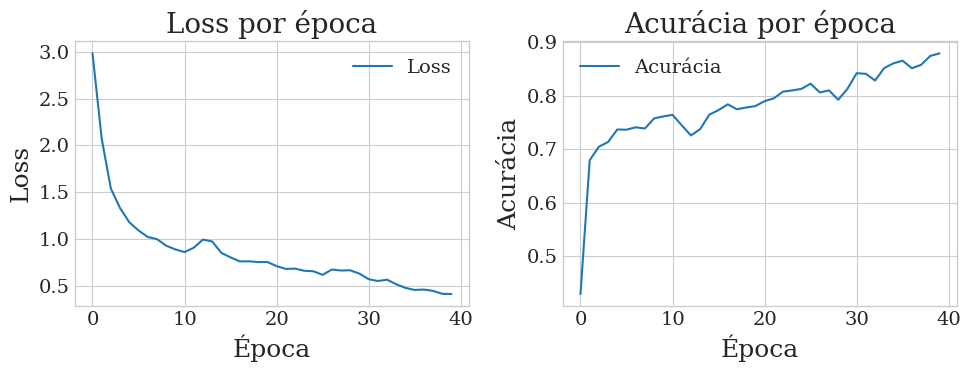

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Acurácia por época")
plt.grid(True)
plt.legend()

plt.tight_layout()

# Salve ANTES do plt.show()
plot_dir = Path("plots/loss_acc")
plot_dir.mkdir(parents=True, exist_ok=True)
plot_filename_base = Path(model_name_saved).name
plt.savefig(plot_dir / f"{plot_filename_base}.png", dpi=300, bbox_inches="tight")

plt.show()

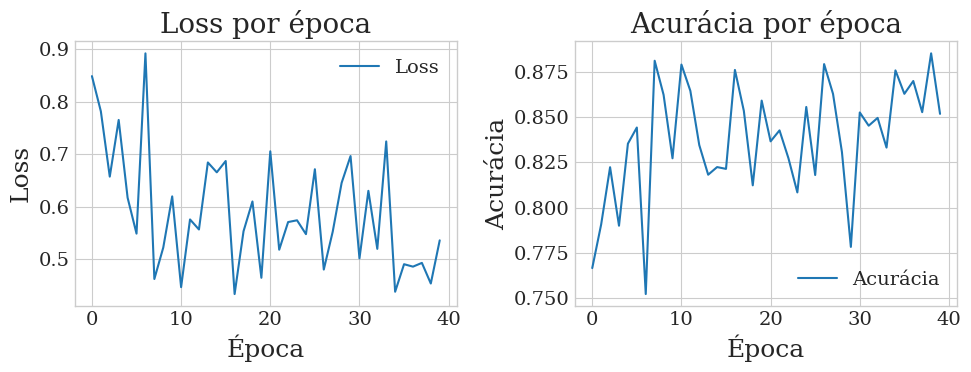

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(validation_loss_history, label="Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(validation_acc_history, label="Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Acurácia por época")
plt.grid(True)
plt.legend()

plt.tight_layout()

# Salve ANTES do plt.show()
plot_dir = Path("plots/loss_acc")
plot_dir.mkdir(parents=True, exist_ok=True)
plot_filename_base = Path(model_name_saved).name
plt.savefig(plot_dir / f"{plot_filename_base}.png", dpi=300, bbox_inches="tight")

plt.show()

In [16]:
lista_validation = [1, 6,7]
processed_validation_dataset = []

for i in lista_validation:
    SEQ_LIST = [i]
    SEQ_LIST_NAME = "".join(str(s) for s in SEQ_LIST)
    print(SEQ_LIST_NAME)

    with open(
        f"./checkpoints_to_ignore/processed_train_dataset/seq{SEQ_LIST_NAME}.pkl", "rb"
    ) as f:
        p = pickle.load(f)
    processed_validation_dataset.extend(p)

    print(len(processed_validation_dataset))

1
1101
6
2202
7
3303


# Inference

Inferência: 100%|██████████| 3303/3303 [00:35<00:00, 92.84it/s] 


Maior acurácia em um único frame: 100.00% (frame índice 2472)
Menor acurácia em um único frame: 0.14% (frame índice 819)
Acurácias abaixo de 90%: 573 frames, porcentagem do dataset: 17.35%
Mediana das acurácias: 93.27%


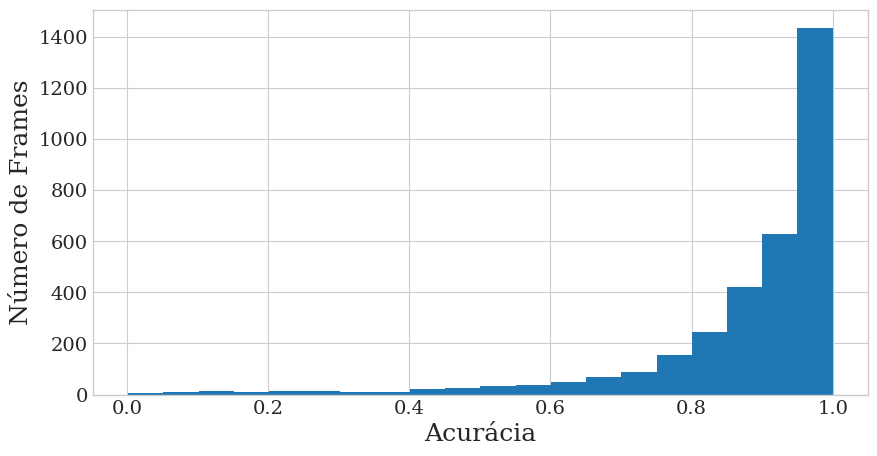

In [19]:
total_correct = 0
total_points = 0
accuracies = []  # Lista para armazenar acurácias individuais

i = 0
model.eval()
with torch.no_grad():
    for point_cloud in tqdm(processed_validation_dataset, desc="Inferência"):
    # for point_cloud in tqdm(processed_train_dataset, desc="Inferência"):
        data = (
            torch.tensor(point_cloud[:, :INPUT_CHANNELS], dtype=torch.float32)
            .unsqueeze(0)
            .to(DEVICE)
        )
        label = point_cloud[:, -2]
        pred, trans = model(data)
        pred = pred.view(-1, NUM_CLASSES)
        pred = pred.argmax(dim=1).cpu().numpy()

        # Calcula acurácia para este frame específico
        correct = (label == pred).sum()
        total = len(label)
        frame_accuracy = correct / total
        if (frame_accuracy > 0.93 and frame_accuracy < 0.95):
            frame_print = i
        i += 1
        accuracies.append(frame_accuracy)

# Agora calculamos as estatísticas
max_accuracy = max(accuracies)
min_accuracy = min(accuracies)
median_accuracy = np.median(accuracies)

# Encontrar índice do melhor e pior frame
best_frame_idx = np.argmax(accuracies)
worst_frame_idx = np.argmin(accuracies)

menores = [acc for acc in accuracies if acc < 0.8]
menores_porcentagem = len(menores) / len(accuracies) * 100
print(
    f"Maior acurácia em um único frame: {max_accuracy*100:.2f}% (frame índice {best_frame_idx})"
)
print(
    f"Menor acurácia em um único frame: {min_accuracy*100:.2f}% (frame índice {worst_frame_idx})"
)
print(
    f"Acurácias abaixo de 90%: {len(menores)} frames, porcentagem do dataset: {menores_porcentagem:.2f}%"
)
print(f"Mediana das acurácias: {median_accuracy*100:.2f}%")

# Opcional: Histograma de distribuição das acurácias
plt.figure(figsize=(10, 5))
plt.hist(accuracies, bins=20)
plt.xlabel("Acurácia")
plt.ylabel("Número de Frames")
plt.grid(True)
plt.show()

In [24]:
point_cloud = processed_validation_dataset[frame_print]

data = (
    torch.tensor(point_cloud[:, :INPUT_CHANNELS], dtype=torch.float32)
    .unsqueeze(0)
    .to(DEVICE)
)
label = point_cloud[:, -2]

# # Carregar o modelo treinado
# model = PointNetSeg(num_classes=NUM_CLASSES).to(DEVICE)
# model.load_state_dict(torch.load("checkpoints/pointnet_epoch_001.pth"))

model.eval()
with torch.no_grad():
    pred, trans = model(data)
    pred = pred.view(-1, NUM_CLASSES)

    # pred_labels = torch.argmax(pred, dim=1).cpu().numpy()
    pred = pred.argmax(dim=1)

# Agora, substituindo os rótulos originais pelos rótulos preditos
# Mantendo as coordenadas xyz no formato original e substituindo o label
result = np.hstack(
    (
        data.squeeze(0).cpu().numpy(),
        label.reshape(-1, 1),
        pred.cpu().numpy().reshape(-1, 1),
    )
)

In [25]:
# Calcula a acurácia usando o array result
true_labels = result[:, -2]
pred_labels = result[:, -1]
accuracy = (true_labels == pred_labels).sum() / len(result)
print(f"Acurácia (amostra): {accuracy*100:.2f}%")
# print(f"[Epoch {epoch:05d}] Loss: {avg_loss:.4f} | Acc: {avg_acc*100:.2f}%")
run_viz(
    result,
    cluster_viz=True,
    show_pred_label=True,
    point_size=3,
    # show_min_max=True,
)
run_viz(
    result,
    cluster_viz=True,
    show_true_label=True,
    point_size=3,
    # show_min_max=True,
)

Acurácia (amostra): 94.50%


In [26]:
frame_print

3295

In [ ]:
lista_validation = [1, 6, 7]
processed_validation_dataset = []

for i in lista_validation:
    SEQ_LIST = [i]
    SEQ_LIST_NAME = "".join(str(s) for s in SEQ_LIST)
    print(SEQ_LIST_NAME)

    with open(
        f"./checkpoints_to_ignore/processed_train_dataset/seq{SEQ_LIST_NAME}.pkl", "rb"
    ) as f:
        p = pickle.load(f)
    processed_validation_dataset.extend(p)

    print(len(processed_validation_dataset))